In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy_financial as npf

In [2]:
#get data
electricity_usage_2020 = pd.read_csv("C:/Users/Aggie/Downloads/Data for candidate 2026.Candidate Version.xlsx - Raw Data.csv")

In [3]:
#drop first row
electricity_usage_2020 = electricity_usage_2020.iloc[1:, :]
#reset index values
electricity_usage_2020.reset_index(drop=True, inplace=True)

In [4]:
#set first row as column names
electricity_usage_2020.columns = electricity_usage_2020.iloc[0]

#remove first row from DataFrame
electricity_usage_2020 = electricity_usage_2020[1:]

In [5]:
#remove commas from numbers
electricity_usage_2020["Electricity usage (kWh)"] = electricity_usage_2020["Electricity usage (kWh)"].astype(str).str.replace(",","")
electricity_usage_2020["Solar electricity generation (kWh)"] = electricity_usage_2020["Solar electricity generation (kWh)"].astype(str).str.replace(",","")

In [6]:
#convert column datatypes
electricity_usage_2020["Hour"] = pd.to_numeric(electricity_usage_2020["Hour"])
electricity_usage_2020["Date/hour start"] = pd.to_datetime(electricity_usage_2020["Date/hour start"],format="%m/%d/%y %H:%M")
electricity_usage_2020[["Solar electricity generation (kWh)", "Electricity usage (kWh)"]] = electricity_usage_2020[["Solar electricity generation (kWh)", "Electricity usage (kWh)"]].apply(pd.to_numeric)

In [7]:
electricity_usage_2020.head()

,Hour,Date/hour start,Solar electricity generation (kWh),Electricity usage (kWh)
1,0,2020-01-01 00:00:00,0.0,1.509849
2,1,2020-01-01 01:00:00,0.0,1.411859
3,2,2020-01-01 02:00:00,0.0,1.023898
4,3,2020-01-01 03:00:00,0.0,0.642000
5,4,2020-01-01 04:00:00,0.0,0.960000


In [8]:
electricity_usage_2020.describe()

,Hour,Date/hour start,Solar electricity generation (kWh),Electricity usage (kWh)
count,8760.000000,8760,8760.000000,8760.000000
mean,11.500000,2020-07-02 07:37:13.972602624,1.116750,7.312704
min,0.000000,2020-01-01 00:00:00,0.000000,-12.624000
25%,5.750000,2020-04-02 05:45:00,0.000000,0.300000
50%,11.500000,2020-07-02 11:30:00,0.024000,0.621000
75%,17.250000,2020-10-01 17:15:00,1.272750,1.686000
max,23.000000,2020-12-31 23:00:00,13.050000,46000.000000
std,6.922582,NaN,2.026098,491.479806


In [9]:
# average solar electricity generated by hour in 2020
solar_electricity_avg = electricity_usage_2020.groupby(by = "Hour").mean()["Solar electricity generation (kWh)"]

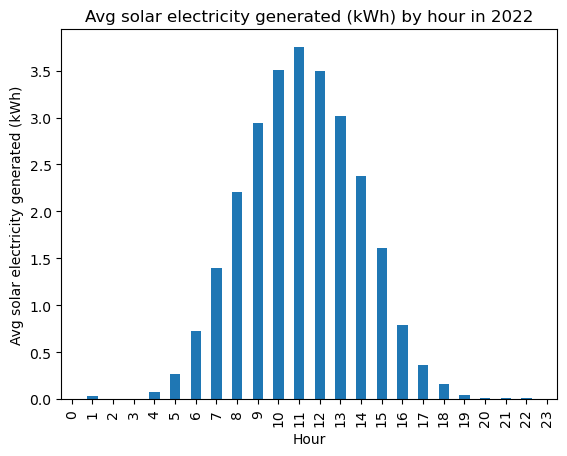

In [10]:
solar_electricity_avg.plot.bar() 
plt.xlabel("Hour")
plt.ylabel("Avg solar electricity generated (kWh)")
plt.title("Avg solar electricity generated (kWh) by hour in 2022")
plt.show()

In [11]:
# average electricity usage by hour in 2020
electricity_usage_avg = electricity_usage_2020.groupby(by = "Hour").mean()["Electricity usage (kWh)"]

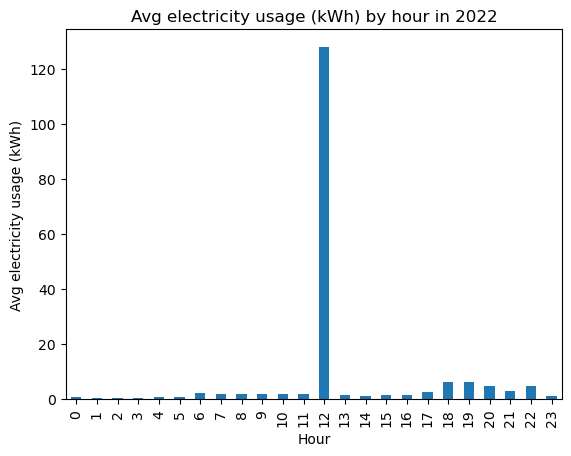

In [12]:
electricity_usage_avg.plot.bar() 
plt.xlabel("Hour")
plt.ylabel("Avg electricity usage (kWh)")
plt.title("Avg electricity usage (kWh) by hour in 2022")
plt.show()

In [13]:
#data cleaning:
#replace solar electricity generated before 06:00hrs and after 18:00hrs with 0
#replace outliers (negative values and more than 70 values) in electricity usage with n/a
electricity_usage_2020["Solar electricity generation (kWh)"] = np.where((electricity_usage_2020["Solar electricity generation (kWh)"] > 0) &
                                                      (electricity_usage_2020["Hour"] <= 6) ,0, electricity_usage_2020["Solar electricity generation (kWh)"])
electricity_usage_2020["Solar electricity generation (kWh)"] = np.where((electricity_usage_2020["Solar electricity generation (kWh)"] > 0) &
                                                      (electricity_usage_2020["Hour"] >= 18 ) ,0, electricity_usage_2020["Solar electricity generation (kWh)"])
electricity_usage_2020["Electricity usage (kWh)"] = np.where((electricity_usage_2020["Electricity usage (kWh)"] < 0) |
                                           (electricity_usage_2020["Electricity usage (kWh)"] >= 10 ),np.nan , electricity_usage_2020["Electricity usage (kWh)"])
electricity_usage_2020 = electricity_usage_2020.dropna()

In [14]:
#calculate electricity required to be bought without battery 
electricity_usage_2020["Electricity required to be bought without battery (kWh)"] = electricity_usage_2020["Electricity usage (kWh)"] - electricity_usage_2020["Solar electricity generation (kWh)"]
electricity_usage_2020["Electricity required to be bought without battery (kWh)"] = np.where((electricity_usage_2020["Electricity required to be bought without battery (kWh)"] < 0) ,0 , electricity_usage_2020["Electricity required to be bought without battery (kWh)"])

In [15]:
#calculate excess solar generated 
electricity_usage_2020["Excess solar generation (kWh)"] = electricity_usage_2020["Solar electricity generation (kWh)"] - electricity_usage_2020["Electricity usage (kWh)"]
#electricity_usage_2020["Excess solar generation (kWh)"] = np.where((electricity_usage_2020["Excess solar generation (kWh)"] < 0) ,0 , electricity_usage_2020["Excess solar generation (kWh)"])

In [16]:
#calculate the battery charge level for a battery with a maximum capacity of 12.5
num_row = len(electricity_usage_2020)
electricity_stored = [0,]

for row in range(1,num_row):
    excess_solar_now = electricity_usage_2020.iloc[row,5]
    prev_electricity = electricity_stored[row-1]
    battery_level = prev_electricity + excess_solar_now
    true_battery_level = max(battery_level,0) if battery_level < 0 else min(battery_level,12.5)
    electricity_stored.append(true_battery_level)

electricity_usage_2020["Battery charge level (kWh)"] = electricity_stored

In [17]:
#calculate electricity required to be bought with battery
electricity_usage_2020["Electricity required to be bought with battery (kWh)"] = electricity_usage_2020["Electricity usage (kWh)"] - electricity_usage_2020["Solar electricity generation (kWh)"] - electricity_usage_2020["Battery charge level (kWh)"]
electricity_usage_2020["Electricity required to be bought with battery (kWh)"] = np.where((electricity_usage_2020["Electricity required to be bought with battery (kWh)"] < 0) ,0 , electricity_usage_2020["Electricity required to be bought with battery (kWh)"])

In [18]:
electricity_usage_2020["Month"] = electricity_usage_2020["Date/hour start"].dt.strftime('%B')

In [19]:
electricity_usage_2020.head(5)

,Hour,Date/hour start,Solar electricity generation (kWh),Electricity usage (kWh),Electricity required to be bought without battery (kWh),Excess solar generation (kWh),Battery charge level (kWh),Electricity required to be bought with battery (kWh),Month
1,0,2020-01-01 00:00:00,0.0,1.509849,1.509849,-1.509849,0.0,1.509849,January
2,1,2020-01-01 01:00:00,0.0,1.411859,1.411859,-1.411859,0.0,1.411859,January
3,2,2020-01-01 02:00:00,0.0,1.023898,1.023898,-1.023898,0.0,1.023898,January
4,3,2020-01-01 03:00:00,0.0,0.642000,0.642000,-0.642000,0.0,0.642000,January
5,4,2020-01-01 04:00:00,0.0,0.960000,0.960000,-0.960000,0.0,0.960000,January


In [20]:
# total cost savings in 2020 if the cost of electricity is 0.17 $/kWh
savings = (electricity_usage_2020["Electricity required to be bought without battery (kWh)"].sum()*0.17) - (electricity_usage_2020["Electricity required to be bought with battery (kWh)"].sum()*0.17)
print (f"Total Savings in $: {round(savings,0)}")

Total Savings in $: 391.0


In [21]:
#tabulation of data
data_monthly = electricity_usage_2020.groupby(by = "Month", as_index = False)[["Solar electricity generation (kWh)","Electricity usage (kWh)","Electricity required to be bought without battery (kWh)","Electricity required to be bought with battery (kWh)"]].sum()
months_in_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data_monthly["Month"] = pd.Categorical(data_monthly["Month"],categories=months_in_order,ordered=True)
data_monthly = data_monthly.sort_values("Month")
data_monthly = data_monthly.reset_index(drop=True)
data_monthly

,Month,Solar electricity generation (kWh),Electricity usage (kWh),Electricity required to be bought without battery (kWh),Electricity required to be bought with battery (kWh)
0,January,240.777,1065.126581,967.185581,893.130134
1,February,421.254,910.578110,771.831110,656.775915
2,March,541.926,984.440650,834.266650,689.111737
3,April,830.964,879.373987,681.406987,495.863656
4,May,1545.471,654.963209,484.410209,187.325271
5,June,1225.968,756.549138,550.458138,273.336321
6,July,1247.712,718.046721,518.645721,203.956174
7,August,1084.173,776.519451,571.544451,283.328472
8,September,804.597,897.805965,704.278965,475.507847
9,October,538.434,823.430585,670.718585,476.790815


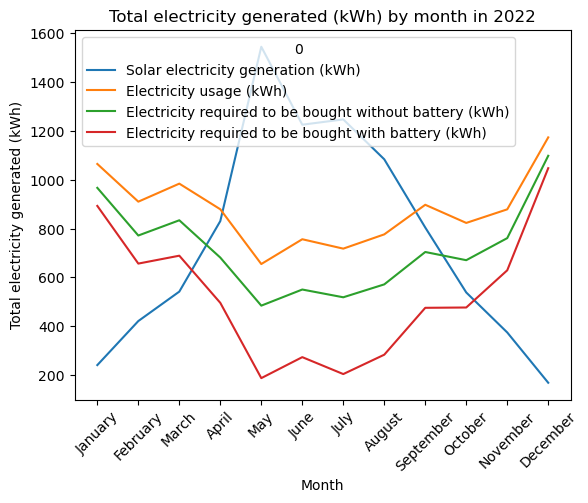

In [22]:
data_monthly.plot() 
plt.xticks(data_monthly.index,months_in_order,rotation=45)
plt.xlabel("Month")
plt.ylabel("Total electricity generated (kWh)")
plt.title("Total electricity generated (kWh) by month in 2022")
plt.show()

In [24]:
# annual savings under scenario a projection
index = list(range(0,21))
year = list(range(2020,2040))
forcast = pd.DataFrame(list(zip(index, year)),columns =["index", "year"])
forcast["price_20_a"] = 0.17*(1.04**forcast["index"])
forcast["savings_a"] = (electricity_usage_2020["Electricity required to be bought without battery (kWh)"].sum()-electricity_usage_2020["Electricity required to be bought with battery (kWh)"].sum())*forcast["price_20_a"]
print(forcast)

    index  year  price_20_a   savings_a
0       0  2020    0.170000  391.386097
1       1  2021    0.176800  407.041540
2       2  2022    0.183872  423.323202
3       3  2023    0.191227  440.256130
4       4  2024    0.198876  457.866375
5       5  2025    0.206831  476.181030
6       6  2026    0.215104  495.228272
7       7  2027    0.223708  515.037402
8       8  2028    0.232657  535.638898
9       9  2029    0.241963  557.064454
10     10  2030    0.251642  579.347033
11     11  2031    0.261707  602.520914
12     12  2032    0.272175  626.621750
13     13  2033    0.283062  651.686620
14     14  2034    0.294385  677.754085
15     15  2035    0.306160  704.864249
16     16  2036    0.318407  733.058819
17     17  2037    0.331143  762.381171
18     18  2038    0.344389  792.876418
19     19  2039    0.358164  824.591475


In [25]:
# npv under scenario a assuming a 6% p.a discount rate
npv_a = npf.npv(0.06,forcast["savings_a"])
print(f"Net Present Value (NPV): {round(npv_a,0)}")

Net Present Value (NPV): 6571.0


In [26]:
# irr under scenario a for a battery costing $7,000
lst = [-7000]+list(forcast["savings_a"])
irr_a = npf.irr(lst)
print(f"Internal Rate of Return (IRR): {round(irr_a,2)}")

Internal Rate of Return (IRR): 0.05


In [27]:
# annual savings under scenario b projection
prices = [0.17]
for x in index:
    prices.append(prices[x]*(1+(0.04+(0.0025*(x+1)))))
forcast["price_20_b"] = pd.Series(prices)
forcast["savings_b"] = (electricity_usage_2020["Electricity required to be bought without battery (kWh)"].sum()-electricity_usage_2020["Electricity required to be bought with battery (kWh)"].sum())*forcast["price_20_b"]
print(forcast)         

    index  year  price_20_a   savings_a  price_20_b    savings_b
0       0  2020    0.170000  391.386097    0.170000   391.386097
1       1  2021    0.176800  407.041540    0.177225   408.020006
2       2  2022    0.183872  423.323202    0.185200   426.380906
3       3  2023    0.191227  440.256130    0.193997   446.633999
4       4  2024    0.198876  457.866375    0.203697   468.965699
5       5  2025    0.206831  476.181030    0.214391   493.586398
6       6  2026    0.215104  495.228272    0.226183   520.733650
7       7  2027    0.223708  515.037402    0.239188   550.675835
8       8  2028    0.232657  535.638898    0.253539   583.716385
9       9  2029    0.241963  557.064454    0.269386   620.198659
10     10  2030    0.251642  579.347033    0.286896   660.511572
11     11  2031    0.261707  602.520914    0.306261   705.096103
12     12  2032    0.272175  626.621750    0.327699   754.452830
13     13  2033    0.283062  651.686620    0.351458   809.150660
14     14  2034    0.2943

In [28]:
# npv under scenario b assuming a 6% p.a discount rate
npv_b = npf.npv(0.06,forcast["savings_b"])
print(f"Net Present Value (NPV): {round(npv_b,0)}")

Net Present Value (NPV): 7657.0


In [29]:
# irr under scenario b for a battery costing $7,000
lst = [-7000]+list(forcast["savings_b"])
irr_b = npf.irr(lst)
print(f"Internal Rate of Return (IRR): {round(irr_b,2)}")

Internal Rate of Return (IRR): 0.06
